<a href="https://colab.research.google.com/github/MonicaKim89/Sign_Recognition/blob/main/%5B0421%5Dretest_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/Projects/Sign Detection/box_detection

/content/drive/MyDrive/Projects/Sign Detection/box_detection


In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12897, done.
remote: Total 12897 (delta 0), reused 0 (delta 0), pack-reused 12897
Receiving objects: 100% (12897/12897), 11.79 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (8960/8960), done.
/content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 4.1 MB/s 
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!unzip post_resized.zip

In [12]:
%cat data.yaml

train: /content/drive/MyDrive/Projects/Sign Detection/box_detection/post_resized/train/images
val: /content/drive/MyDrive/Projects/Sign Detection/box_detection/post_resized/val/images

nc: 1
names: ['box']

In [13]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

    print(num_classes)

1


In [15]:
#this is the model configuration we will use for our tutorial 
%cat /content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5/models/yolov5s.yaml

cat: /content/drive/MyDrive/Projects/Sign: No such file or directory
cat: Detection/box_detection/yolov5/models/yolov5s.yaml: No such file or directory


In [16]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [17]:
%%writetemplate /content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [20]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5
!python train.py --img 200 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/yolov5l.yaml --weights '' --name yolov5s_results  --cache

/content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5
github: ⚠️ WARNING: code is out of date by 1003 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov5l.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[200, 200], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results2', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recomme

In [21]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 496), started 0:15:57 ago. (Use '!kill 496' to kill it.)

<IPython.core.display.Javascript object>

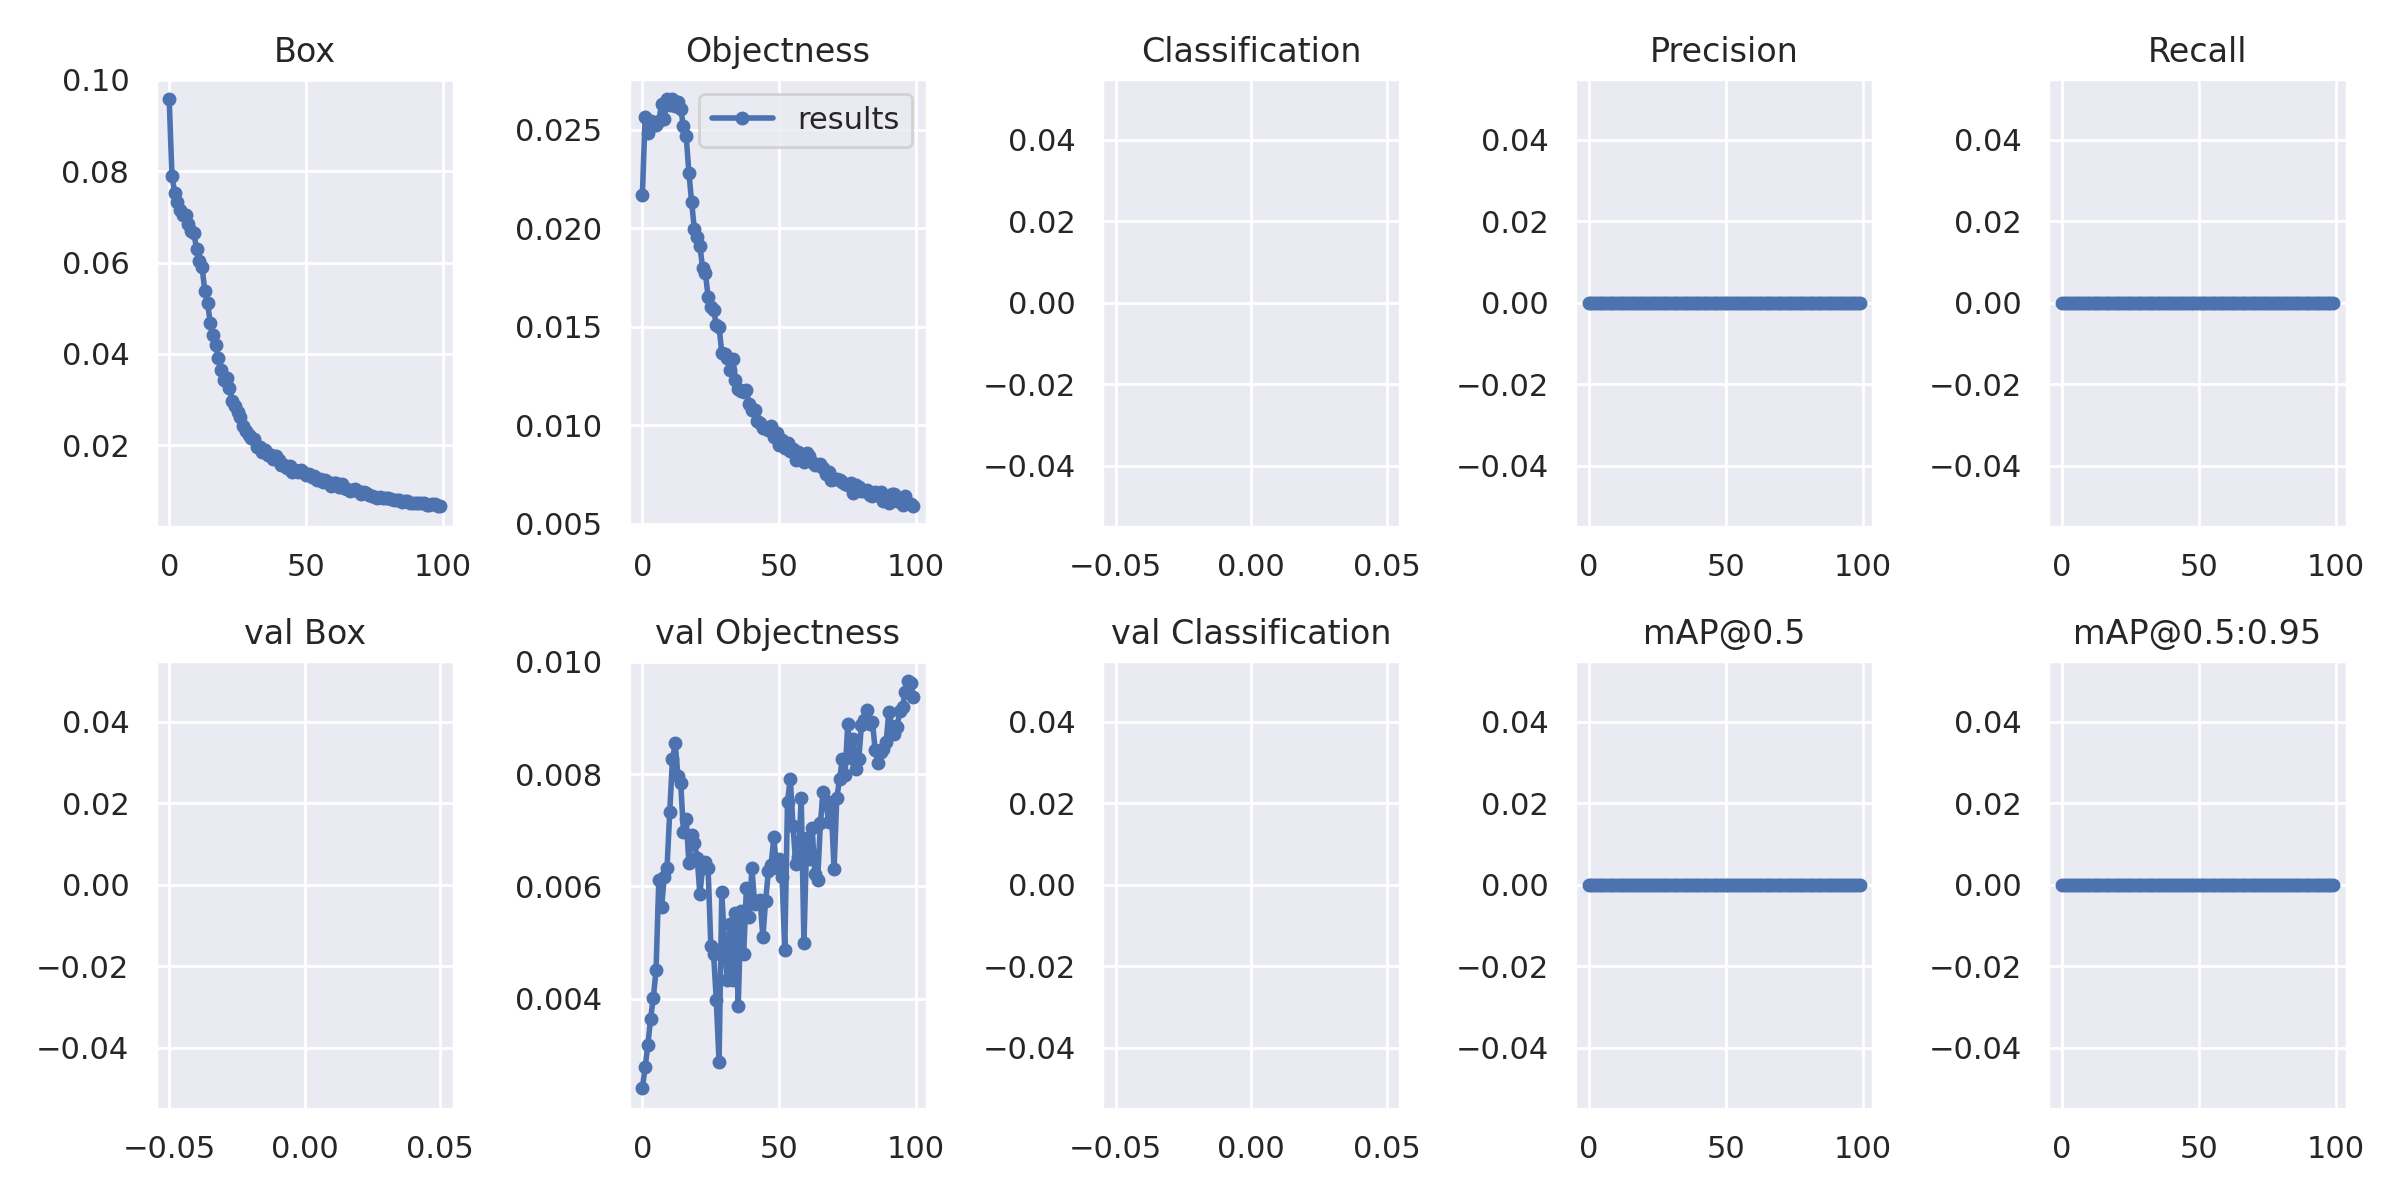

In [22]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


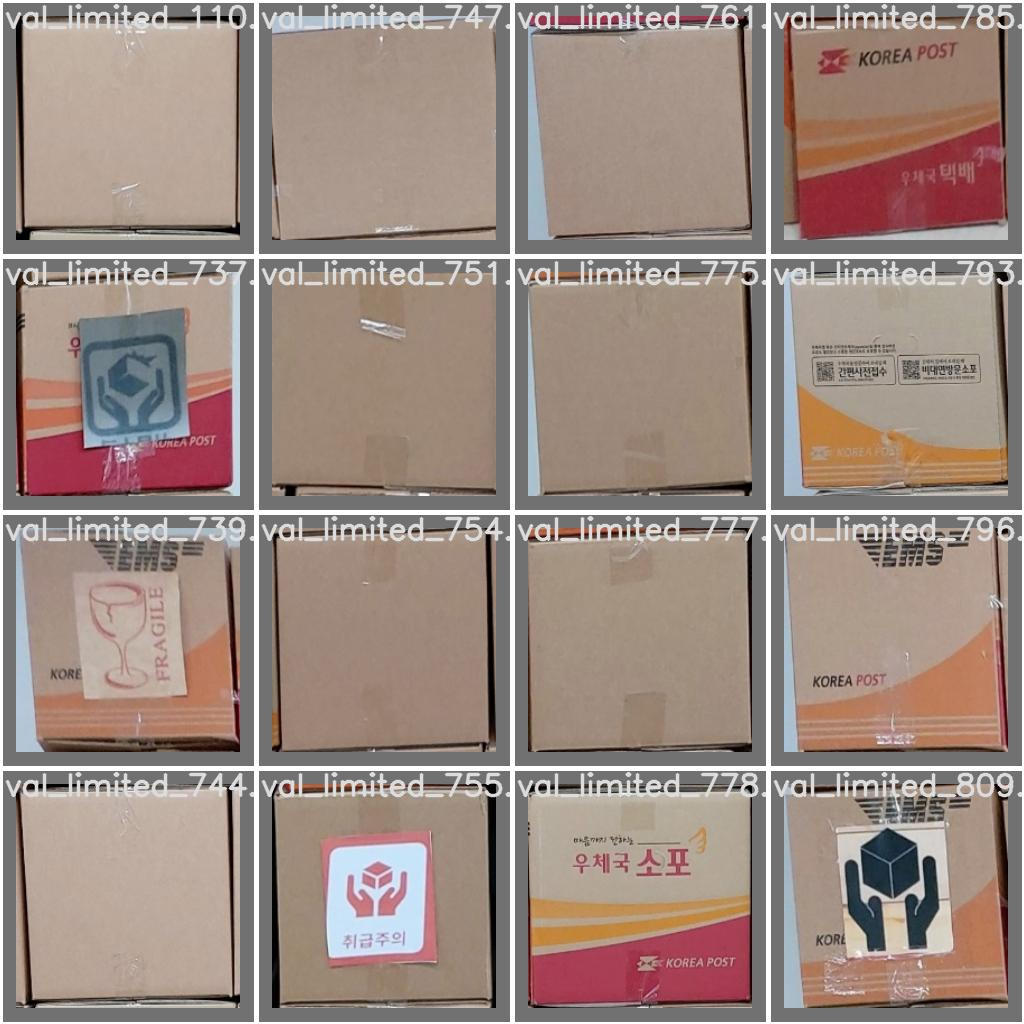

In [25]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


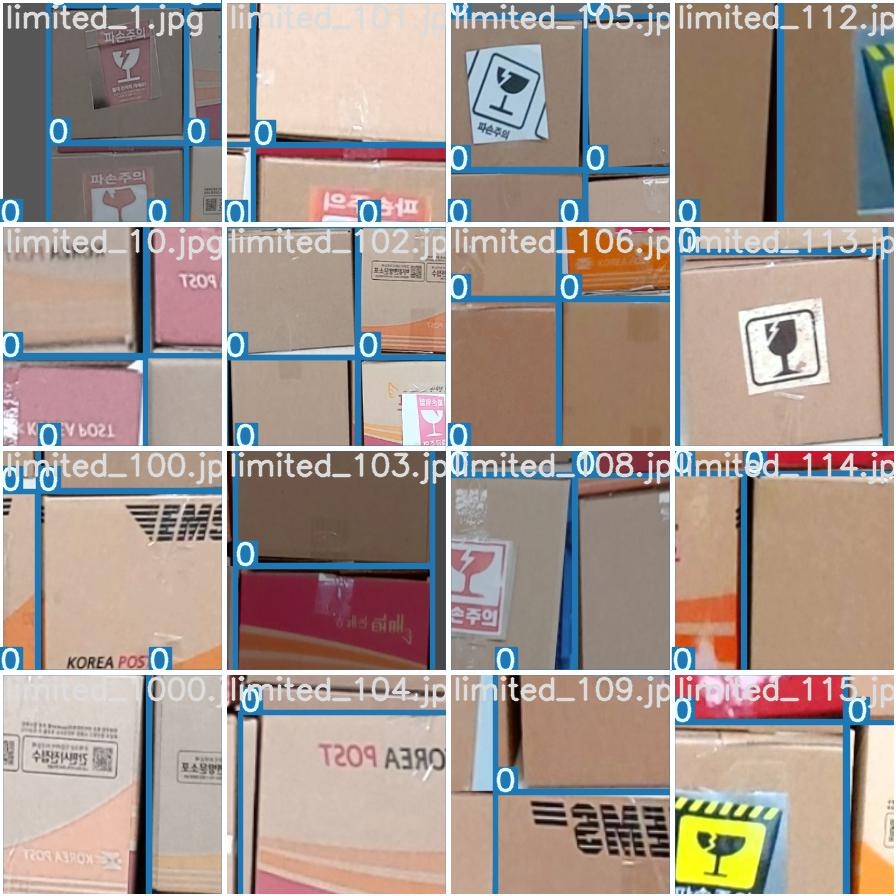

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [26]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [27]:
%ls runs/train/yolov5s_results/weights

### DETECTOR

detect.py 꼭 바꿔주기  
save_path 잘 지정하기

In [ ]:
# ### yolov5 detected object cropper
# ### set result location
# ### rename the file

# import argparse
# import os
# import time
# from pathlib import Path
# import numpy as np
# import random

# import cv2
# import torch
# import torch.backends.cudnn as cudnn
# from numpy import random

# from models.experimental import attempt_load
# from utils.datasets import LoadStreams, LoadImages
# from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
#     scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
# from utils.plots import plot_one_box
# from utils.torch_utils import select_device, load_classifier, time_synchronized


# def detect(save_img=False):
#     source, weights, view_img, save_txt, imgsz = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size
#     webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
#         ('rtsp://', 'rtmp://', 'http://'))

#     # Directories
#     save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
#     (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

#     # Initialize
#     set_logging()
#     device = select_device(opt.device)
#     half = device.type != 'cpu'  # half precision only supported on CUDA

#     # Load model
#     model = attempt_load(weights, map_location=device)  # load FP32 model
#     stride = int(model.stride.max())  # model stride
#     imgsz = check_img_size(imgsz, s=stride)  # check img_size
#     if half:
#         model.half()  # to FP16

#     # Second-stage classifier
#     classify = False
#     if classify:
#         modelc = load_classifier(name='resnet101', n=2)  # initialize
#         modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

#     # Set Dataloader
#     vid_path, vid_writer = None, None
#     if webcam:
#         view_img = check_imshow()
#         cudnn.benchmark = True  # set True to speed up constant image size inference
#         dataset = LoadStreams(source, img_size=imgsz, stride=stride)
#     else:
#         save_img = True
#         dataset = LoadImages(source, img_size=imgsz, stride=stride)

#     # Get names and colors
#     names = model.module.names if hasattr(model, 'module') else model.names
#     colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

#     # Run inference
#     if device.type != 'cpu':
#         model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
#     t0 = time.time()
#     for path, img, im0s, vid_cap in dataset:
#         img = torch.from_numpy(img).to(device)
#         img = img.half() if half else img.float()  # uint8 to fp16/32
#         img /= 255.0  # 0 - 255 to 0.0 - 1.0
#         if img.ndimension() == 3:
#             img = img.unsqueeze(0)

#         # Inference
#         t1 = time_synchronized()
#         pred = model(img, augment=opt.augment)[0]

#         # Apply NMS
#         pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
#         t2 = time_synchronized()

#         # Apply Classifier
#         if classify:
#             pred = apply_classifier(pred, modelc, img, im0s)

#         # Process detections
#         for i, det in enumerate(pred):  # detections per image
#             if webcam:  # batch_size >= 1
#                 p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
#             else:
#                 p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

#             p = Path(p)  # to Path
#             save_path = str(save_dir / p.name)  # img.jpg
#             txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
#             s += '%gx%g ' % img.shape[2:]  # print string
#             gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
#             if len(det):
#                 # Rescale boxes from img_size to im0 size
#                 det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

#                 # Print results
#                 for c in det[:, -1].unique():
#                     n = (det[:, -1] == c).sum()  # detections per class
#                     s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

#                 # Write results
#                  # Write results
#                 for *xyxy, conf, cls in det:
#                     if save_txt:  # Write to file
#                         xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
#                         with open(txt_path + '.txt', 'a') as f:
#                             f.write(('%g ' * 5 + '\n') % (cls, *xywh))  # label format
                    
#                     if save_img or view_img:  # Add bbox to image
#                         label = '%s %.2f' % (names[int(cls)], conf)
#                         plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
                    
#                     save_obj = True
#                     if save_obj:
#                         for k in range(len(det)):
#                             x,y,w,h=int(xyxy[0]), int(xyxy[1]), int(xyxy[2] - xyxy[0]), int(xyxy[3] - xyxy[1])                   
#                             img_ = im0.astype(np.uint8)
#                             crop_img=img_[y:y+ h, x:x + w]                          
                                
#                             #!!rescale image !!!

#                             random_num = random.randint(1,100)
#                             filename=p.name
#                             # print(filename)
#                             filepath='/content/post_resized/test/results/'
#                             print(filepath+'{}_'.format(random_num)+filename)
#                             cv2.imwrite(filepath+'{}_'.format(random_num)+filename, crop_img) 
                            
#                         else:
#                             print("There is no detected object")
#                             continue

#             # Print time (inference + NMS)
#             print(f'{s}Done. ({t2 - t1:.3f}s)')

#             # Stream results
#             if view_img:
#                 cv2.imshow(str(p), im0)
#                 cv2.waitKey(1)  # 1 millisecond

#             # Save results (image with detections)
#             if save_img:
#                 if dataset.mode == 'image':
#                     cv2.imwrite(save_path, im0)
#                 else:  # 'video'
#                     if vid_path != save_path:  # new video
#                         vid_path = save_path
#                         if isinstance(vid_writer, cv2.VideoWriter):
#                             vid_writer.release()  # release previous video writer

#                         fourcc = 'mp4v'  # output video codec
#                         fps = vid_cap.get(cv2.CAP_PROP_FPS)
#                         w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#                         h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#                         vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*fourcc), fps, (w, h))
#                     vid_writer.write(im0)

#     if save_txt or save_img:
#         s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
#         print(f"Results saved to {save_dir}{s}")

#     print(f'Done. ({time.time() - t0:.3f}s)')


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--weights', nargs='+', type=str, default='yolov5s.pt', help='model.pt path(s)')
#     parser.add_argument('--source', type=str, default='data/images', help='source')  # file/folder, 0 for webcam
#     parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
#     parser.add_argument('--conf-thres', type=float, default=0.25, help='object confidence threshold')
#     parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
#     parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
#     parser.add_argument('--view-img', action='store_true', help='display results')
#     parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
#     parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
#     parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
#     parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
#     parser.add_argument('--augment', action='store_true', help='augmented inference')
#     parser.add_argument('--update', action='store_true', help='update all models')
#     parser.add_argument('--project', default='runs/detect', help='save results to project/name')
#     parser.add_argument('--name', default='exp', help='save results to project/name')
#     parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
#     opt = parser.parse_args()
#     print(opt)
#     check_requirements(exclude=('pycocotools', 'thop'))

#     with torch.no_grad():
#         if opt.update:  # update all models (to fix SourceChangeWarning)
#             for opt.weights in ['yolov5s.pt', 'yolov5m.pt', 'yolov5l.pt', 'yolov5x.pt']:
#                 detect()
#                 strip_optimizer(opt.weights)
#         else:
#             detect()

In [31]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5
!python box_detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 1000 --conf 0.9 --source ../post_resized/test/images

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/85_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/73_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/87_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/17_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/80_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/59_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/22_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/93_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/6_20220126_153341.jpg
/content/drive/MyDrive/Projects/Sign Detection/box_detection/test/result/56_20220126_153341.jpg
/cont

GROUND TRUTH AUGMENTED TRAINING DATA:


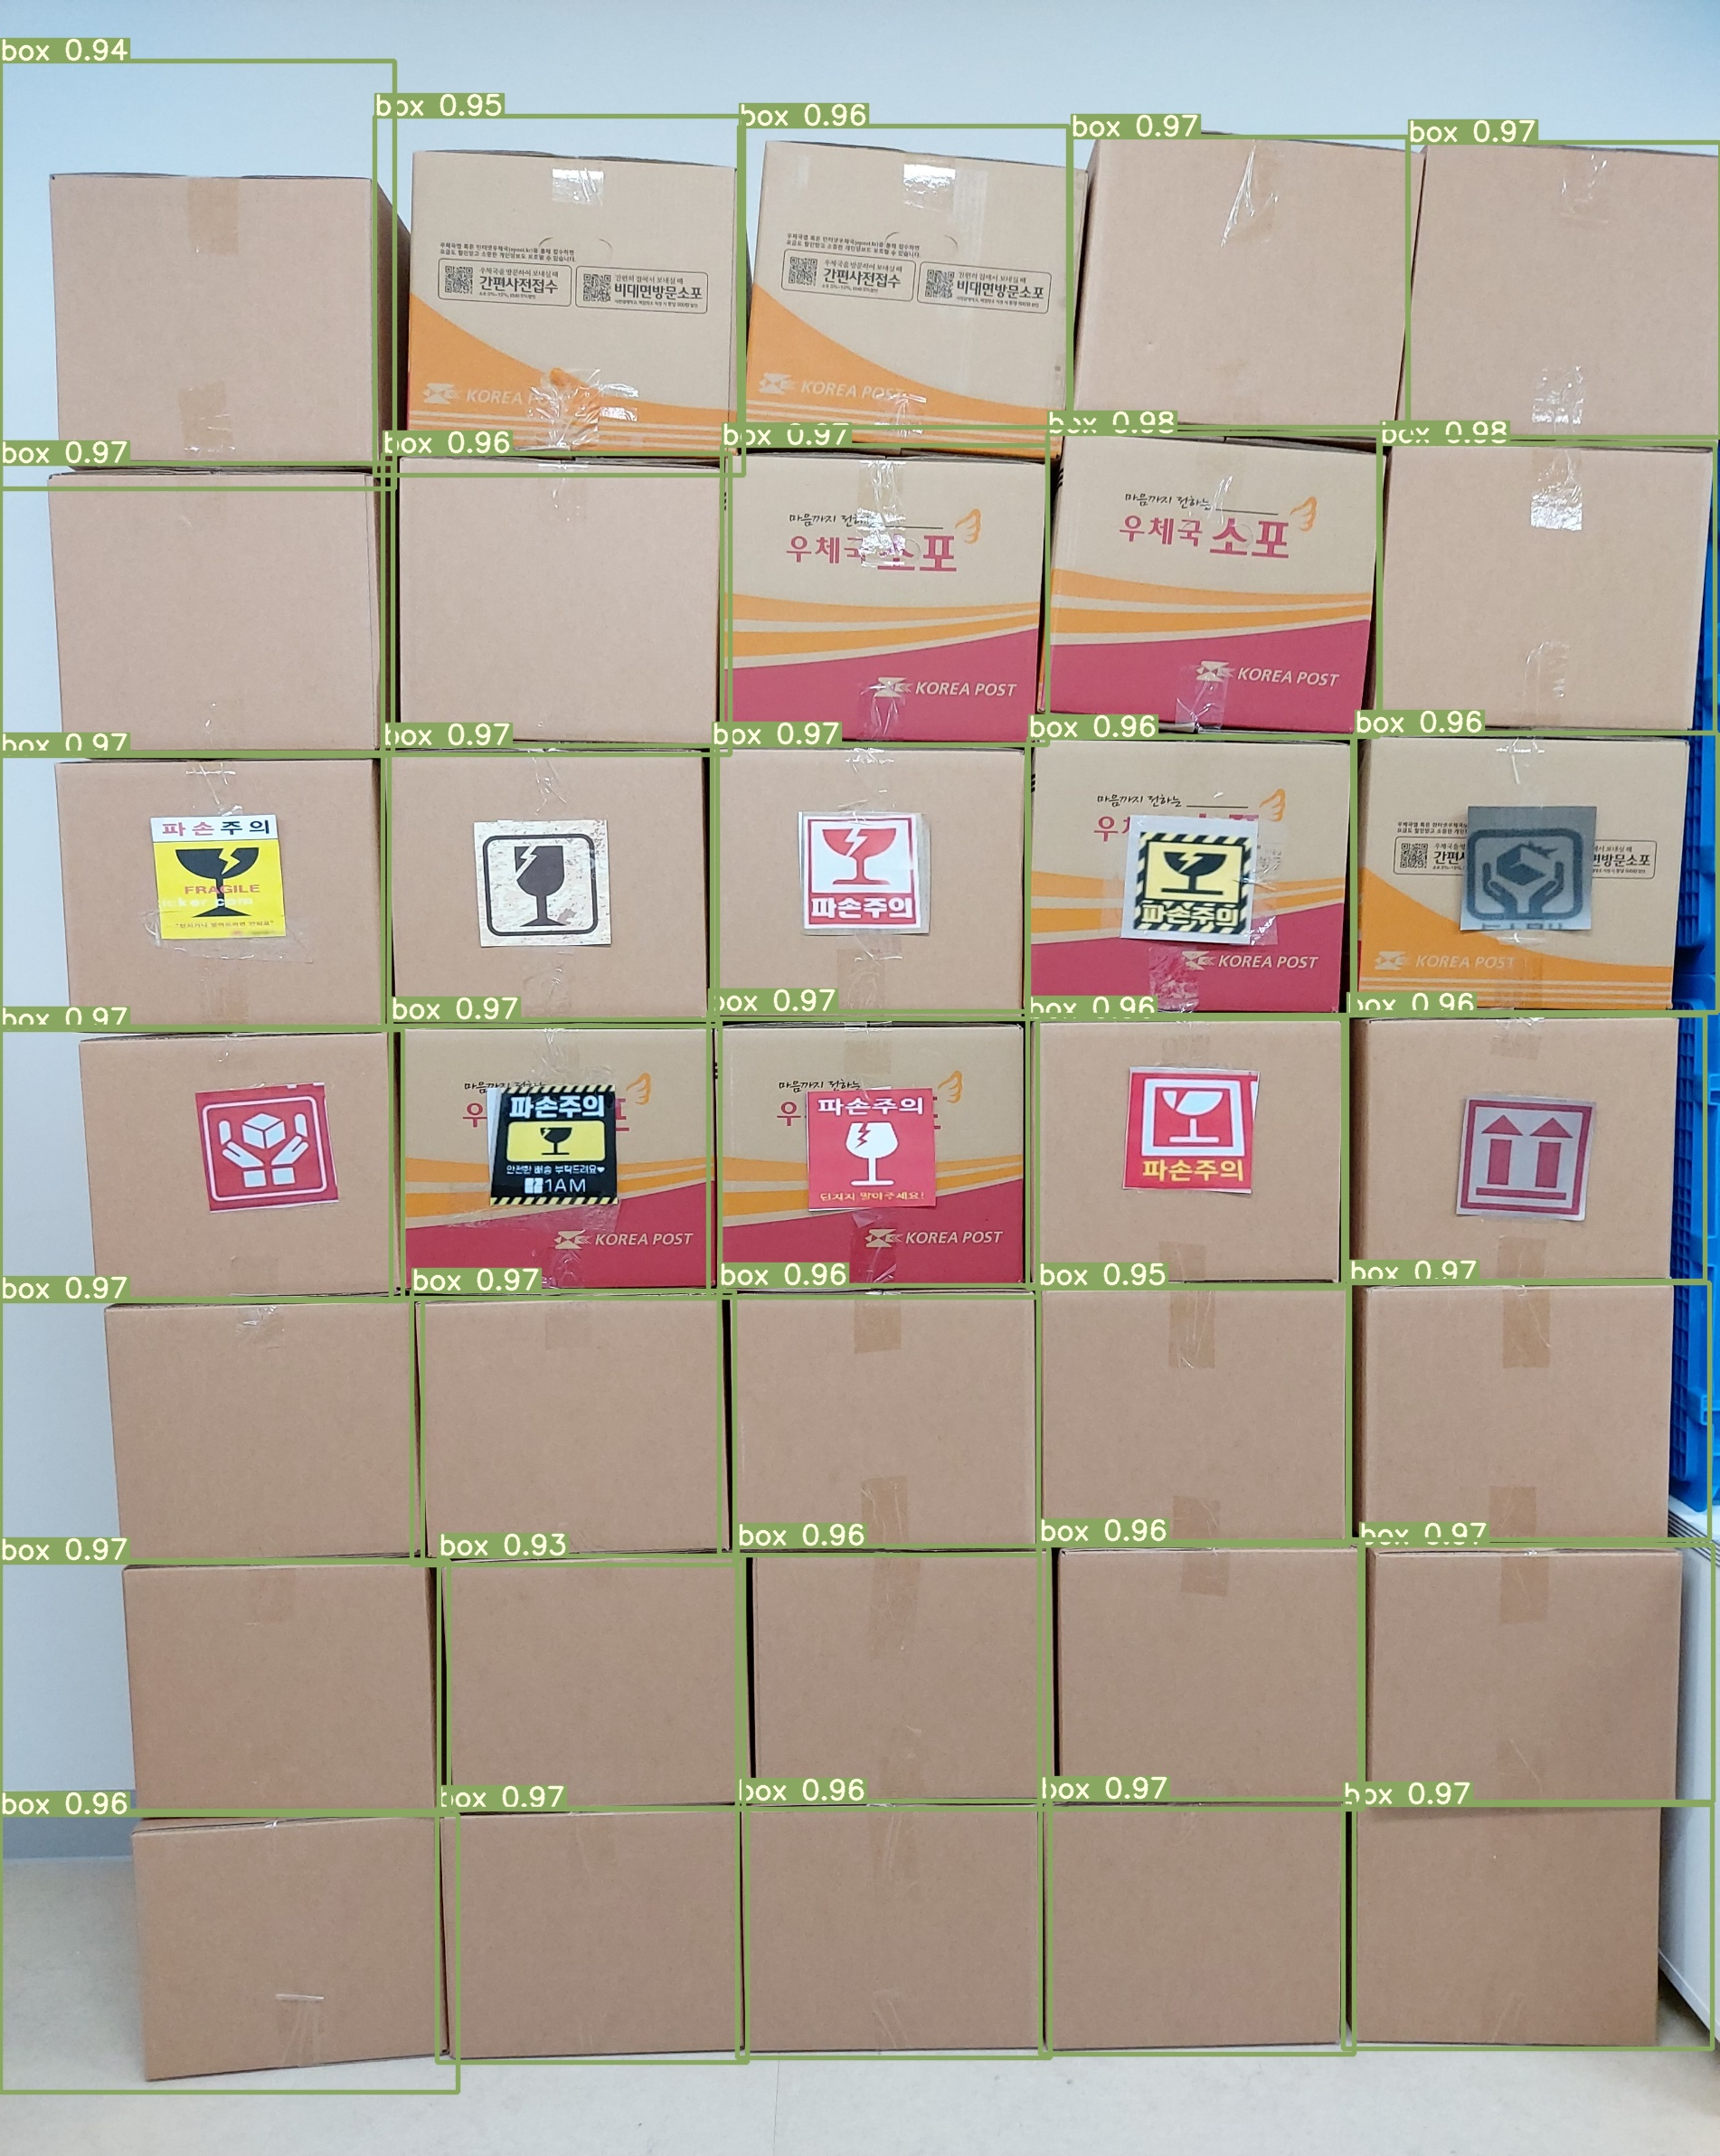

In [32]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Projects/Sign Detection/box_detection/yolov5/runs/detect/exp4/20220126_172825.jpg', width=900)

### EXPORT

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive

In [ ]:
torch.save